In [2]:
import numpy as np
import xarray as xr
from pyremap import LatLonGridDescriptor, Remapper
from pyremap.polar import get_polar_descriptor_from_file

In [2]:
ds = xr.open_dataset('/Users/jonniebarnsley/data/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/Amon/tas/gn/v20190227/tas_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc')
def _add_periodic_lon(ds, lonDim):

    nLon = ds.sizes[lonDim]
    lonIndices = xr.DataArray(np.append(np.arange(nLon), [0]),
                                  dims=('newLon',))
    ds.load()
    ds = ds.isel({lonDim: lonIndices})
    ds = ds.rename({'newLon': lonDim})
    return ds

lonDim = ds.lon.dims[0]
lonRange = ds.lon[-1].values - ds.lon[0].values
ds = _add_periodic_lon(ds, lonDim)
ds.to_netcdf('intermediate_data.nc')

/Users/jonniebarnsley/opt/anaconda3/envs/pyremap/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tas' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_49117/266743926.py:9: UserWarning: rename 'newLon' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({'newLon': lonDim})


In [6]:
ds = xr.open_dataset('/Users/jonniebarnsley/data/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/Amon/tas/gn/v20190227/tas_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412_tmp.nc')

In [7]:

#inDescriptor = LatLonGridDescriptor.create(ds.lat.values, ds.lon.values)
inDescriptor = LatLonGridDescriptor.read(
    '/Users/jonniebarnsley/data/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/Amon/tas/gn/v20190227/tas_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412_tmp.nc',
    lat_var_name='lat',
    lon_var_name='lon'
    )
inDescriptor.regional = True
outDescriptor = get_polar_descriptor_from_file(
    '/Users/jonniebarnsley/code/phd/local/data/bisicles_grid_pole_centered.nc',
    projection='antarctic')

In [8]:
remapper = Remapper(
    map_filename='pyremap_testmap7.nc',
    src_descriptor=inDescriptor,
    dst_descriptor=outDescriptor,
    method='bilinear'
)
remapper.build_map()

running: ESMF_RegridWeightGen --source /var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/tmprh6gi11v/src_mesh.nc --destination /var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/tmprh6gi11v/dst_mesh.nc --weight pyremap_testmap7.nc --method bilinear --netcdf4 --src_regional --dst_regional --ignore_unmapped
 Starting weight generation with these inputs: 
   Source File: /var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/tmprh6gi11v/src_mesh.nc
   Destination File: /var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/tmprh6gi11v/dst_mesh.nc
   Weight File: pyremap_testmap7.nc
   Source File is in SCRIP format
   Source Grid is a regional grid
   Source Grid is a logically rectangular grid
   Use the center coordinates of the source grid to do the regrid
   Destination File is in SCRIP format
   Destination Grid is a regional grid
   Destination Grid is a logically rectangular grid
   Use the center coordinates of the destination grid to do the regrid
   Regrid Method: bilinear
   Pole option: NONE

In [9]:
#ds = ds.drop_vars(['lat', 'lon'])
nt = ds.sizes['time']
print(ds.tas.shape)

for tIndex in range(nt)[:5]:
    print(tIndex)
    dsIn = ds.isel(time=tIndex)
    dsOut = remapper.remap_numpy(dsIn, renormalization_threshold=0.1)

    #dsOut = dsOut.transpose('y', 'x')


(1980, 192, 289)
0
1
2
3
4


In [10]:
dsOut

<xarray.Dataset> Size: 14MB
Dimensions:    (x: 768, y: 768, nbnd: 2)
Coordinates:
  * x          (x) float64 6kB -3.068e+06 -3.06e+06 ... 3.06e+06 3.068e+06
  * y          (y) float64 6kB -3.068e+06 -3.06e+06 ... 3.06e+06 3.068e+06
    time       object 8B 1850-05-15 12:00:00
    lat        (y, x) float64 5MB -51.52 -51.57 -51.62 ... -51.62 -51.57 -51.52
    lon        (y, x) float64 5MB -135.0 -135.1 -135.1 ... 44.85 44.93 45.0
Dimensions without coordinates: nbnd
Data variables:
    tas        (y, x) float64 5MB 278.1 278.1 278.0 278.0 ... 277.0 277.0 277.1
    time_bnds  (nbnd) object 16B ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                4
    cesm_casename:          b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-30T22:37:15Z
    ...                     ...
    variant_label:          r1i1p1f1
    branch_time_in_parent:  20075.0
    branch_time_in_child:   674885.0
    branch_method:          standard
    history:                /Users/jonniebarnsley/opt/anaconda3/envs/pyremap/...
    mesh_name:              6136x6136km_8km_antarctic_stereo

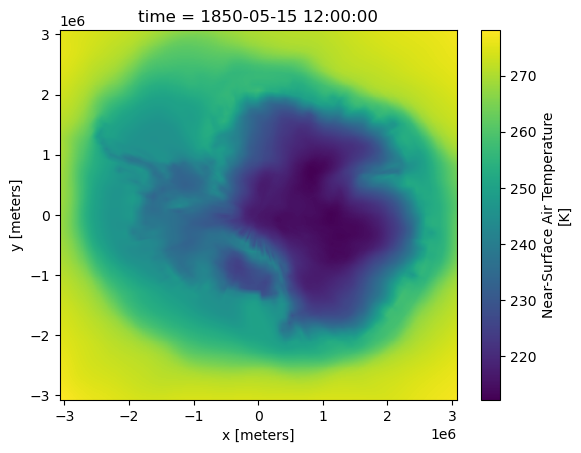

In [11]:
dsOut.tas.plot()

In [26]:
test = remapper.remap_numpy(ds, renormalization_threshold=0.1)

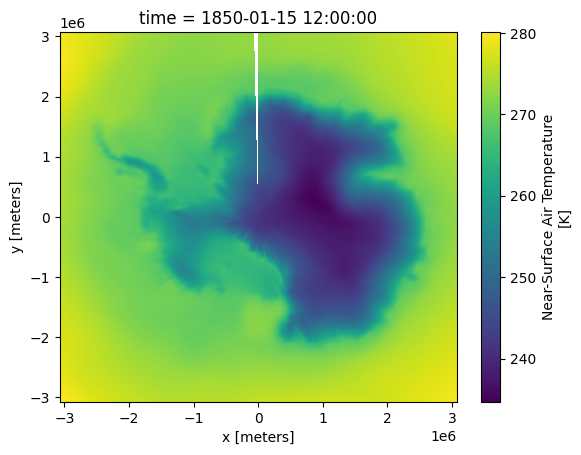

In [27]:
test.isel(time=0).tas.plot()

In [17]:
file = xr.open_dataset('/Users/jonniebarnsley/data/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/Amon/tas/gn/v20190227/test.nc')
file

<xarray.Dataset> Size: 788MB
Dimensions:    (time: 165, y: 768, x: 768, nbnd: 2)
Coordinates:
  * time       (time) int64 1kB 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014
  * y          (y) float64 6kB 4e+03 1.2e+04 2e+04 ... 6.132e+06 6.14e+06
  * x          (x) float64 6kB 4e+03 1.2e+04 2e+04 ... 6.132e+06 6.14e+06
    lat        (y, x) float64 5MB ...
    lon        (y, x) float64 5MB ...
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, y, x) float64 779MB ...
    time_bnds  (time, nbnd) object 3kB ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                4
    cesm_casename:          b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-30T22:37:15Z
    ...                     ...
    variant_label:          r1i1p1f1
    branch_time_in_parent:  20075.0
    branch_time_in_child:   674885.0
    branch_method:          standard
    history:                /Users/jonniebarnsley/code/phd/local/lib/regrid_C...
    mesh_name:              6136x6136km_8km_antarctic_stereo

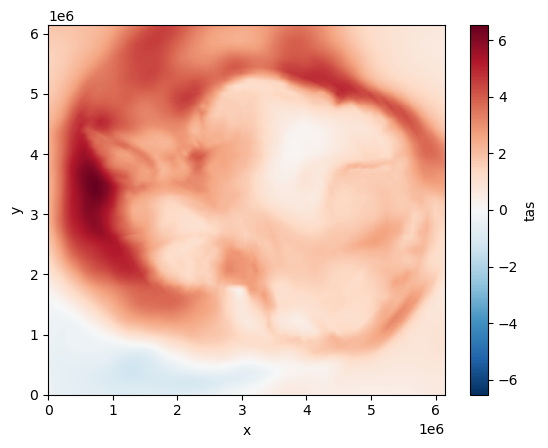

In [20]:
tas = file.tas
dtas = tas.isel(time=-1) - tas.isel(time=0)
dtas.plot()

In [24]:
file = xr.open_dataset('/Users/jonniebarnsley/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r2i1p1f2/Amon/tas/gn/v20190903/tas_Amon_GISS-E2-1-G_historical_r2i1p1f2_gn_190101-195012.nc')
file

<xarray.Dataset> Size: 31MB
Dimensions:    (time: 600, bnds: 2, lat: 90, lon: 144)
Coordinates:
  * time       (time) object 5kB 1901-01-16 12:00:00 ... 1850-01-01 00:00:00
  * lat        (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon        (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 10kB ...
    lat_bnds   (lat, bnds) float64 1kB ...
    lon_bnds   (lon, bnds) float64 2kB ...
    tas        (time, lat, lon) float32 31MB ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  7300.0
    contact:                Kenneth Lo (cdkkl@giss.nasa.gov)
    ...                     ...
    title:                  GISS-E2-1-G output prepared for CMIP6
    tracking_id:            hdl:21.14100/05a16538-86d5-48ea-99b6-480e5fc2e550
    variable_id:            tas
    variant_label:          r2i1p1f2
    license:                CMIP6 model data produced by NASA Goddard Institu...
    cmor_version:           3.3.2

In [25]:
annual = file.groupby('time.year').mean('time')
annual

<xarray.Dataset> Size: 391kB
Dimensions:    (year: 7, bnds: 2, lat: 90, lon: 144)
Coordinates:
  * year       (year) int64 56B 1850 1901 1902 1903 1904 1905 1906
  * lat        (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon        (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (year, bnds) object 112B 1850-01-01 00:00:00 ... 1906-03-02 00...
    lat_bnds   (year, lat, bnds) float64 10kB -90.0 -88.0 -88.0 ... 88.0 90.0
    lon_bnds   (year, lon, bnds) float64 16kB 0.0 2.5 2.5 ... 357.5 357.5 360.0
    tas        (year, lat, lon) float32 363kB 0.0 0.0 0.0 ... 156.3 156.3 156.3
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  7300.0
    contact:                Kenneth Lo (cdkkl@giss.nasa.gov)
    ...                     ...
    title:                  GISS-E2-1-G output prepared for CMIP6
    tracking_id:            hdl:21.14100/05a16538-86d5-48ea-99b6-480e5fc2e550
    variable_id:            tas
    variant_label:          r2i1p1f2
    license:                CMIP6 model data produced by NASA Goddard Institu...
    cmor_version:           3.3.2

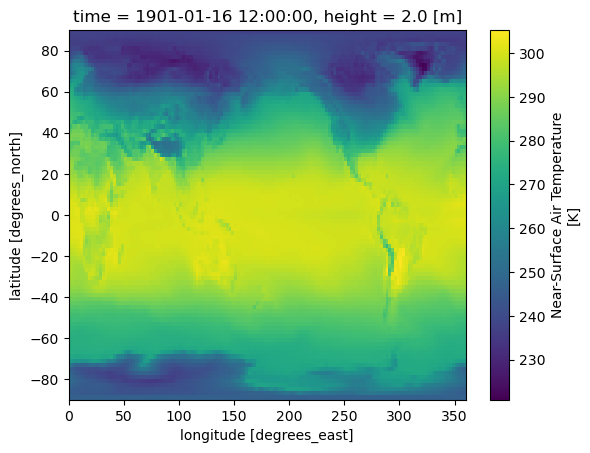

In [28]:
file.tas.isel(time=0).plot()

In [3]:
file = xr.open_dataset('/Users/jonniebarnsley/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp126/r1i1p1f1/Amon/tas/bisicles-8km/v20210211/tas_Amon_CESM2-WACCM_ssp126_r1i1p1f1_bisicles-8km_201501-206412.nc')

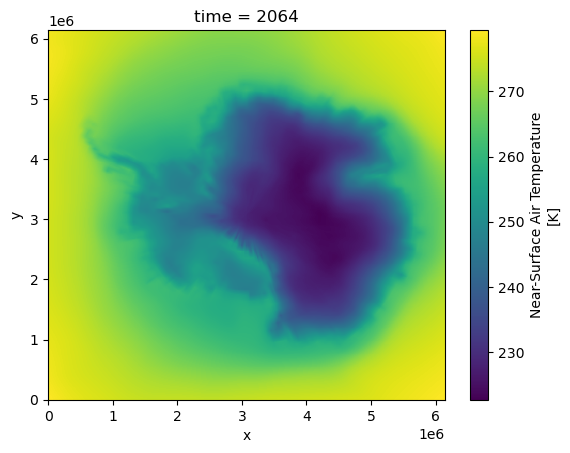

In [4]:
file.tas.isel(time=-1).plot()